In \[ \]:

    import pandas as pd
    import json
    import numpy as np
    import folium
    from folium import plugins
    import matplotlib.pyplot as plt 
    import seaborn as sns
    import io
    import warnings
    import re
    warnings.filterwarnings(action='ignore')

## 전처리<a href="#전처리" class="anchor-link">¶</a>

### 인구수, 학원수, 교원 1인당 학생수, 요양 관리시설수<a href="#인구수,-학원수,-교원-1인당-학생수,-요양-관리시설수" class="anchor-link">¶</a>

In \[ \]:

    # csv 제목 4개를 순서대로 list로 저장

    csv_list = ["아파트매매가격", "총인구", "요양기관수", "교원1인당_학생수", "인구_천명당_사설학원수"]

In \[ \]:

    # csv 불러오기

    for i in range(len(csv_list)):
      df = '/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/{}.csv'.format(csv_list[i])
      globals()['data{}'.format(i)] = pd.read_csv(df, encoding = 'cp949')

In \[ \]:

    # 전체 데이터 프레임에서 특정 값이 있는 열을 찾아주는 함수 생성
    def find_col_with_value(df, value):
        for col in df:
            if (df[col] == value).any():
                 return col

    # 행정구역을 index로 설정
    for i in range(len(csv_list)):
      a = find_col_with_value(globals()['data{}'.format(i)], "종로구")
      globals()['data{}'.format(i)].set_index(a, inplace = True)

In \[ \]:

    # 각 csv에서 2019년 정도를 담고 있는 column의 이름을 list로 저장
    c = ["2019 ", "2019", "2019 4/4"]

    # 각 csv에서 2019년 정보를 series로 추출하기
    for i in range(len(csv_list)):
      globals()['s{}'.format(i)] = globals()['data{}'.format(i)][globals()['data{}'.format(i)].columns[globals()['data{}'.format(i)].columns.isin(c)]]

### 지하철역 구별로 정리<a href="#지하철역-구별로-정리" class="anchor-link">¶</a>

In \[ \]:

    from google.colab import drive
    drive.mount('/content/drive')

    Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

In \[ \]:

    df = '/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울교통공사_도시철도역사정보.csv'
    data = pd.read_csv(df, encoding = 'utf-8')
    data

Out\[ \]:

|     | 역번호 | 역사명   | 노선번호 | 노선명              | 영문역사명                | 한자역사명 | 환승역구분 | 환승노선번호      | 환승노선명                            | 역위도    | 역경도     | 운영기관명   | 역사도로명주소                                   | 역사전화번호 | 데이터기준일자 |
|-----|--------|----------|----------|---------------------|---------------------------|------------|------------|-------------------|---------------------------------------|-----------|------------|--------------|--------------------------------------------------|--------------|----------------|
| 0   | 206    | 신당     | S1102    | 서울 도시철도 2호선 | Sindang                   | 新堂       | 환승역     | S1106             | 서울 도시철도 6호선                   | 37.565829 | 127.018102 | 서울교통공사 | 서울특별시 중구 퇴계로 지하 431-1 (신당동)       | 02-6110-2061 | 2021-04-09     |
| 1   | 207    | 상왕십리 | S1102    | 서울 도시철도 2호선 | Sangwangsimni             | 上往十里   | 일반역     | NaN               | NaN                                   | 37.564171 | 127.029352 | 서울교통공사 | 서울특별시 성동구 왕십리로 지하 374 (하왕십리동) | 02-6110-2071 | 2021-04-09     |
| 2   | 208    | 왕십리   | S1102    | 서울 도시철도 2호선 | Wangsimni                 | 往十里     | 환승역     | S1105+I4105+I4107 | 서울 도시철도 5호선+분당선+경의중앙선 | 37.561525 | 127.037508 | 서울교통공사 | 서울특별시 성동구 왕십리로 지하300(행당동)       | 02-6110-2081 | 2021-04-09     |
| 3   | 209    | 한양대   | S1102    | 서울 도시철도 2호선 | Hanyang Univ.             | 漢陽大     | 일반역     | NaN               | NaN                                   | 37.555222 | 127.043492 | 서울교통공사 | 서울특별시 성동구 왕십리로 206 (행당동)          | 02-6110-2091 | 2021-04-09     |
| 4   | 210    | 뚝섬     | S1102    | 서울 도시철도 2호선 | Ttukseom                  | 纛島       | 일반역     | NaN               | NaN                                   | 37.547122 | 127.047365 | 서울교통공사 | 서울특별시 성동구 아차산로 18 (성수동1가)        | 02-6110-2101 | 2021-04-09     |
| ... | ...    | ...      | ...      | ...                 | ...                       | ...        | ...        | ...               | ...                                   | ...       | ...        | ...          | ...                                              | ...          | ...            |
| 268 | 4131   | 삼전     | S1109    | 서울 도시철도 9호선 | Samjeon                   | 三 田      | 일반역     | NaN               | NaN                                   | 37.504745 | 127.087781 | 서울교통공사 | 서울특별시 송파구 백제고분로 187                 | 02-2656-0931 | 2021-04-09     |
| 269 | 4132   | 석촌고분 | S1109    | 서울 도시철도 9호선 | Seokchon Gobun            | 石村古墳   | 일반역     | NaN               | NaN                                   | 37.502028 | 127.096622 | 서울교통공사 | 서울특별시 송파구 삼학사로 53                    | 02-2656-0932 | 2021-04-09     |
| 270 | 4133   | 석촌     | S1109    | 서울 도시철도 9호선 | Seokchon(Hansol Hospital) | 石村       | 환승역     | S1108             | 서울 도시철도 8호선                   | 37.505949 | 127.106346 | 서울교통공사 | 서울특별시 송파구 송파대로 439                   | 02-2656-0933 | 2021-04-09     |
| 271 | 4134   | 송파나루 | S1109    | 서울 도시철도 9호선 | Songpanaru                | 松坡나루   | 일반역     | NaN               | NaN                                   | 37.510120 | 127.113123 | 서울교통공사 | 서울특별시 송파구 오금로 165                     | 02-2656-0934 | 2021-04-09     |
| 272 | 4135   | 한성백제 | S1109    | 서울 도시철도 9호선 | Hanseong Baekje           | 漢城百?    | 일반역     | NaN               | NaN                                   | 37.516865 | 127.118185 | 서울교통공사 | 서울특별시 송파구 위례성대로 51                  | 02-2656-0935 | 2021-04-09     |

273 rows × 15 columns

In \[ \]:

    data["행정구역"] = 0

In \[ \]:

    for i in range(len(data)):
        # print(data.loc[i][2])
        a = data.loc[i][12]
        m = re.compile("[\w]+구").findall(a)
        # print(m)
        data["행정구역"][i] = m[0]
        # print(data["행정구역"][i])

    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      
    /usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      iloc._setitem_with_indexer(indexer, value)

In \[ \]:

    data

Out\[ \]:

|     | 역번호 | 역사명   | 노선번호 | 노선명              | 영문역사명                | 한자역사명 | 환승역구분 | 환승노선번호      | 환승노선명                            | 역위도    | 역경도     | 운영기관명   | 역사도로명주소                                   | 역사전화번호 | 데이터기준일자 | 행정구역 |
|-----|--------|----------|----------|---------------------|---------------------------|------------|------------|-------------------|---------------------------------------|-----------|------------|--------------|--------------------------------------------------|--------------|----------------|----------|
| 0   | 206    | 신당     | S1102    | 서울 도시철도 2호선 | Sindang                   | 新堂       | 환승역     | S1106             | 서울 도시철도 6호선                   | 37.565829 | 127.018102 | 서울교통공사 | 서울특별시 중구 퇴계로 지하 431-1 (신당동)       | 02-6110-2061 | 2021-04-09     | 중구     |
| 1   | 207    | 상왕십리 | S1102    | 서울 도시철도 2호선 | Sangwangsimni             | 上往十里   | 일반역     | NaN               | NaN                                   | 37.564171 | 127.029352 | 서울교통공사 | 서울특별시 성동구 왕십리로 지하 374 (하왕십리동) | 02-6110-2071 | 2021-04-09     | 성동구   |
| 2   | 208    | 왕십리   | S1102    | 서울 도시철도 2호선 | Wangsimni                 | 往十里     | 환승역     | S1105+I4105+I4107 | 서울 도시철도 5호선+분당선+경의중앙선 | 37.561525 | 127.037508 | 서울교통공사 | 서울특별시 성동구 왕십리로 지하300(행당동)       | 02-6110-2081 | 2021-04-09     | 성동구   |
| 3   | 209    | 한양대   | S1102    | 서울 도시철도 2호선 | Hanyang Univ.             | 漢陽大     | 일반역     | NaN               | NaN                                   | 37.555222 | 127.043492 | 서울교통공사 | 서울특별시 성동구 왕십리로 206 (행당동)          | 02-6110-2091 | 2021-04-09     | 성동구   |
| 4   | 210    | 뚝섬     | S1102    | 서울 도시철도 2호선 | Ttukseom                  | 纛島       | 일반역     | NaN               | NaN                                   | 37.547122 | 127.047365 | 서울교통공사 | 서울특별시 성동구 아차산로 18 (성수동1가)        | 02-6110-2101 | 2021-04-09     | 성동구   |
| ... | ...    | ...      | ...      | ...                 | ...                       | ...        | ...        | ...               | ...                                   | ...       | ...        | ...          | ...                                              | ...          | ...            | ...      |
| 268 | 4131   | 삼전     | S1109    | 서울 도시철도 9호선 | Samjeon                   | 三 田      | 일반역     | NaN               | NaN                                   | 37.504745 | 127.087781 | 서울교통공사 | 서울특별시 송파구 백제고분로 187                 | 02-2656-0931 | 2021-04-09     | 송파구   |
| 269 | 4132   | 석촌고분 | S1109    | 서울 도시철도 9호선 | Seokchon Gobun            | 石村古墳   | 일반역     | NaN               | NaN                                   | 37.502028 | 127.096622 | 서울교통공사 | 서울특별시 송파구 삼학사로 53                    | 02-2656-0932 | 2021-04-09     | 송파구   |
| 270 | 4133   | 석촌     | S1109    | 서울 도시철도 9호선 | Seokchon(Hansol Hospital) | 石村       | 환승역     | S1108             | 서울 도시철도 8호선                   | 37.505949 | 127.106346 | 서울교통공사 | 서울특별시 송파구 송파대로 439                   | 02-2656-0933 | 2021-04-09     | 송파구   |
| 271 | 4134   | 송파나루 | S1109    | 서울 도시철도 9호선 | Songpanaru                | 松坡나루   | 일반역     | NaN               | NaN                                   | 37.510120 | 127.113123 | 서울교통공사 | 서울특별시 송파구 오금로 165                     | 02-2656-0934 | 2021-04-09     | 송파구   |
| 272 | 4135   | 한성백제 | S1109    | 서울 도시철도 9호선 | Hanseong Baekje           | 漢城百?    | 일반역     | NaN               | NaN                                   | 37.516865 | 127.118185 | 서울교통공사 | 서울특별시 송파구 위례성대로 51                  | 02-2656-0935 | 2021-04-09     | 송파구   |

273 rows × 16 columns

In \[ \]:

    a = data["행정구역"][:]
    s5 = a.value_counts()
    s5.sort_values(ascending = False)

Out\[ \]:

    송파구     29
    중구      23
    강남구     21
    마포구     16
    종로구     15
    성동구     14
    은평구     13
    노원구     13
    강동구     12
    서초구     12
    동작구     12
    영등포구    11
    광진구     11
    강서구     10
    용산구     10
    성북구      9
    중랑구      8
    구로구      7
    동대문구     6
    양천구      5
    서대문구     5
    관악구      4
    강북구      3
    도봉구      3
    금천구      1
    Name: 행정구역, dtype: int64

### 대규모 점포 개수<a href="#대규모-점포-개수" class="anchor-link">¶</a>

In \[ \]:

    df = '/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울특별시_대규모점포_인허가_정보.csv'
    data = pd.read_csv(df, encoding = 'cp949')
    data

Out\[ \]:

|     | 영업상태명 | 상세영업상태명 | 지번주소                                            | 도로명주소                                                |
|-----|------------|----------------|-----------------------------------------------------|-----------------------------------------------------------|
| 0   | 영업/정상  | 정상영업       | 서울특별시 종로구 낙원동 288번지 낙원상가           | 서울특별시 종로구 삼일대로 428 낙원상가 506호 (낙원동)    |
| 1   | 영업/정상  | 정상영업       | 서울특별시 종로구 낙원동 288번지 낙원상가           | 서울특별시 종로구 삼일대로 428 낙원상가 (낙원동)          |
| 2   | 영업/정상  | 정상영업       | 서울특별시 종로구 예지동 6번지 1호                  | NaN                                                       |
| 3   | 영업/정상  | 정상영업       | 서울특별시 성동구 성수동1가 656-1208 성수만세주유소 | 서울특별시 성동구 왕십리로 109 성수만세주유소 (성수동1가) |
| 4   | 영업/정상  | 정상영업       | 서울특별시 종로구 서린동 33호                       | NaN                                                       |
| ... | ...        | ...            | ...                                                 | ...                                                       |
| 701 | 영업/정상  | 정상영업       | 서울특별시 양천구 신정3동 1183번지 12호             | 서울특별시 양천구 중앙로 255-1 (신정동)                   |
| 702 | 영업/정상  | 영업개시전     | 서울특별시 광진구 구의동 66-61                      | 서울특별시 광진구 광나루로 531 (구의동)                   |
| 703 | 영업/정상  | 정상영업       | 서울특별시 중랑구 면목3.8동 499번지 4호             | 서울특별시 중랑구 면목로 357 (면목동)                     |
| 704 | 영업/정상  | 정상영업       | 서울특별시 중랑구 면목동 168번지 2호                | 서울특별시 중랑구 사가정로 332 (면목동)                   |
| 705 | 영업/정상  | 정상영업       | 서울특별시 중랑구 신내2동 645번지                   | 서울특별시 중랑구 신내로 201 (신내동)                     |

706 rows × 4 columns

In \[ \]:

    # NaN값을 0으로 치환
    data.fillna(0, inplace = True)

    # 지번주소 컬럼의 0값을 도로명 주소 값으로 채워주기
    for i in range(len(data)):
        if data.loc[i][2] == 0:
            data.loc[i][2] = data.loc[i][3]

In \[ \]:

    # 행정구역 컬럼 생성

    data["행정구역"] = 0

    # 지번주소 컬럼에서 행정구역만 뽑아오기

    for i in range(len(data)):
        a = data.loc[i][2]
        m = re.compile("[\w]+구").findall(a)
        data["행정구역"][i] = m[0]

    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      # Remove the CWD from sys.path while we load stuff.
    /usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      iloc._setitem_with_indexer(indexer, value)

In \[ \]:

    a = data["행정구역"][:]
    s6 = a.value_counts()
    s6.sort_values(ascending = False)

Out\[ \]:

    중구      59
    강남구     50
    송파구     45
    성북구     42
    영등포구    39
    구로구     38
    동대문구    33
    마포구     30
    은평구     29
    서초구     29
    강서구     27
    양천구     26
    광진구     26
    강동구     24
    용산구     23
    금천구     23
    관악구     23
    성동구     22
    강북구     22
    종로구     20
    노원구     19
    동작구     16
    도봉구     15
    중랑구     14
    서대문구    12
    Name: 행정구역, dtype: int64

### 1세대당 주차대수<a href="#1세대당-주차대수" class="anchor-link">¶</a>

In \[ \]:

    df = '/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울특별시_공동주택_아파트_정보.csv'
    data = pd.read_csv(df, encoding = 'utf-8')
    data

Out\[ \]:

|      | 번호  | k-아파트코드 | k-아파트명                    | k-단지분류(아파트,주상복합등등) | 주소(시군구) | k-복도유형 | k-난방방식 | k-전체동수 | k-전체세대수 | k-연면적 | k-주거전용면적 | 주차대수 |
|------|-------|--------------|-------------------------------|---------------------------------|--------------|------------|------------|------------|--------------|----------|----------------|----------|
| 0    | 39    | A13527001    | 도곡동양재디오빌              | 주상복합                        | 강남구       | 복도식     | 개별난방   | 1.0        | 155.0        | 9783.0   | 4261.0         | 125.0    |
| 1    | 53    | A13510001    | 청담삼성1차                   | 아파트                          | 강남구       | 혼합식     | 개별난방   | 1.0        | 158.0        | 20894.0  | 11595.0        | 160.0    |
| 2    | 66    | A13583301    | 논현동부센트레빌              | 아파트                          | 강남구       | 계단식     | 개별난방   | 4.0        | 160.0        | 30443.0  | 15710.0        | 239.0    |
| 3    | 69    | A13508001    | 역삼휴먼터치빌                | 주상복합                        | 강남구       | 복도식     | 개별난방   | 1.0        | 160.0        | 12415.0  | 4785.0         | 123.0    |
| 4    | 86    | A13508002    | 역삼경남                      | 주상복합                        | 강남구       | 계단식     | 개별난방   | 1.0        | 164.0        | 30232.0  | 13661.0        | 183.0    |
| ...  | ...   | ...          | ...                           | ...                             | ...          | ...        | ...        | ...        | ...          | ...      | ...            | ...      |
| 2549 | 40007 | A10025159    | 한양수자인사가정파크아파트    | 아파트                          | 중랑구       | 계단식     | 개별난방   | 8.0        | 497.0        | 73098.0  | 35187.0        | 580.0    |
| 2550 | 40010 | A10025137    | 신내글로리움아파트            | 아파트                          | 중랑구       | 복도식     | 지역난방   | 1.0        | 229.0        | 20760.0  | 9058.0         | 161.0    |
| 2551 | 40096 | A10024741    | 사가정 센트럴 아이파크 아파트 | 아파트                          | 중랑구       | 혼합식     | 개별난방   | 11.0       | 1505.0       | 244759.0 | 120894.0       | 2076.0   |
| 2552 | 40102 | A10024703    | 면목 라온 프라이빗 아파트     | 아파트                          | 중랑구       | 계단식     | 개별난방   | 4.0        | 453.0        | 63364.0  | 33165.0        | 557.0    |
| 2553 | 40153 | A10024443    | 쌍용더플래티넘용마산          | NaN                             | 중랑구       | 계단식     | 개별난방   | 5.0        | NaN          | 36654.0  | 23377.0        | 278.0    |

2554 rows × 12 columns

In \[ \]:

    # NaN값을 0으로 치환
    data.dropna(subset = ["k-전체세대수"], axis = 0, inplace = True)
    data.dropna(subset = ["주차대수"], axis = 0, inplace = True)

    # index 재설정(NaN값을 가진 행을 drop 시켰으므로 index가 공백이 생겼다)
    data.reset_index(drop=True, inplace=True)

    # 세대당_주차대수 컬럼 생성
    data["세대당_주차대수"] = 0.1

    # "주소(시군구)" -> "행정구역"으로 컬럼명 변경
    data.rename(columns = {"주소(시군구)" : "행정구역"}, inplace = True)

In \[ \]:

    for i in range(len(data)):
        data["세대당_주차대수"][i] = round((data["주차대수"][i] / data["k-전체세대수"][i]), 2)
    data

    /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      

Out\[ \]:

|      | 번호  | k-아파트코드 | k-아파트명                    | k-단지분류(아파트,주상복합등등) | 행정구역 | k-복도유형 | k-난방방식 | k-전체동수 | k-전체세대수 | k-연면적 | k-주거전용면적 | 주차대수 | 세대당_주차대수 |
|------|-------|--------------|-------------------------------|---------------------------------|----------|------------|------------|------------|--------------|----------|----------------|----------|-----------------|
| 0    | 39    | A13527001    | 도곡동양재디오빌              | 주상복합                        | 강남구   | 복도식     | 개별난방   | 1.0        | 155.0        | 9783.0   | 4261.0         | 125.0    | 0.81            |
| 1    | 53    | A13510001    | 청담삼성1차                   | 아파트                          | 강남구   | 혼합식     | 개별난방   | 1.0        | 158.0        | 20894.0  | 11595.0        | 160.0    | 1.01            |
| 2    | 66    | A13583301    | 논현동부센트레빌              | 아파트                          | 강남구   | 계단식     | 개별난방   | 4.0        | 160.0        | 30443.0  | 15710.0        | 239.0    | 1.49            |
| 3    | 69    | A13508001    | 역삼휴먼터치빌                | 주상복합                        | 강남구   | 복도식     | 개별난방   | 1.0        | 160.0        | 12415.0  | 4785.0         | 123.0    | 0.77            |
| 4    | 86    | A13508002    | 역삼경남                      | 주상복합                        | 강남구   | 계단식     | 개별난방   | 1.0        | 164.0        | 30232.0  | 13661.0        | 183.0    | 1.12            |
| ...  | ...   | ...          | ...                           | ...                             | ...      | ...        | ...        | ...        | ...          | ...      | ...            | ...      | ...             |
| 2541 | 20681 | A10025855    | e편한세상화랑대아파트         | 아파트                          | 중랑구   | 계단식     | 개별난방   | 12.0       | 719.0        | 116254.0 | 55401.0        | 917.0    | 1.28            |
| 2542 | 40007 | A10025159    | 한양수자인사가정파크아파트    | 아파트                          | 중랑구   | 계단식     | 개별난방   | 8.0        | 497.0        | 73098.0  | 35187.0        | 580.0    | 1.17            |
| 2543 | 40010 | A10025137    | 신내글로리움아파트            | 아파트                          | 중랑구   | 복도식     | 지역난방   | 1.0        | 229.0        | 20760.0  | 9058.0         | 161.0    | 0.70            |
| 2544 | 40096 | A10024741    | 사가정 센트럴 아이파크 아파트 | 아파트                          | 중랑구   | 혼합식     | 개별난방   | 11.0       | 1505.0       | 244759.0 | 120894.0       | 2076.0   | 1.38            |
| 2545 | 40102 | A10024703    | 면목 라온 프라이빗 아파트     | 아파트                          | 중랑구   | 계단식     | 개별난방   | 4.0        | 453.0        | 63364.0  | 33165.0        | 557.0    | 1.23            |

2546 rows × 13 columns

In \[ \]:

    s7 = data.세대당_주차대수.groupby(data.행정구역).mean()
    s7.sort_values(ascending = False)

Out\[ \]:

    행정구역
    용산구     1.365932
    서초구     1.175217
    은평구     1.113796
    강남구     1.111869
    송파구     1.093984
    중구      1.093889
    광진구     1.093651
    마포구     1.030708
    영등포구    1.016395
    동작구     1.006190
    성동구     0.999528
    강서구     0.979869
    종로구     0.962400
    중랑구     0.957273
    양천구     0.954957
    강동구     0.952718
    구로구     0.948651
    동대문구    0.944839
    성북구     0.922114
    서대문구    0.916216
    금천구     0.914615
    관악구     0.860312
    도봉구     0.853939
    강북구     0.813590
    노원구     0.756863
    Name: 세대당_주차대수, dtype: float64

### 단지당 동수<a href="#단지당-동수" class="anchor-link">¶</a>

In \[ \]:

    # 아파트정보
    apartment_info_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/아파트정보.csv", encoding='euc-kr')
    apartment_info = apartment_info_raw

    # 열 선택
    apartment_info = apartment_info[["주소(시군구)", "k-전체동수", "k-전체세대수","k-연면적", "주차대수"]]

    # 행 삭제
    apartment_info = apartment_info.drop(index = 0, axis=0)

    # 컬럼명 변경
    apartment_info.columns = ["행정구역", "전체동수", "전체세대수","연면적", "주차대수"]

    apartment_info.head()

Out\[ \]:

|     | 행정구역 | 전체동수 | 전체세대수 | 연면적  | 주차대수 |
|-----|----------|----------|------------|---------|----------|
| 1   | 강남구   | 1.0      | 158.0      | 20894.0 | 160.0    |
| 2   | 강남구   | 4.0      | 160.0      | 30443.0 | 239.0    |
| 3   | 강남구   | 1.0      | 160.0      | 12415.0 | 123.0    |
| 4   | 강남구   | 1.0      | 164.0      | 30232.0 | 183.0    |
| 5   | 강남구   | 3.0      | 167.0      | 20121.0 | 0.0      |

In \[ \]:

    # 구별 단지당 동수

    # 구별 단지수, 세대수 구하기
    danji_dong = pd.pivot_table(apartment_info,
                         index = '행정구역',
                         values = ['전체동수', "전체세대수"],
                         aggfunc = 'sum')

    # 구별 아파트수
    apart_num = pd.pivot_table(apartment_info,
                         index = '행정구역', values = "전체동수",
                         aggfunc = 'count')

    # 두 데이터프레임 합치기
    apartment_complex = pd.merge(danji_dong, apart_num, on = "행정구역")

    # 단지당 동수 파생변수 만들기
    apartment_complex["단지당 동수"] = apartment_complex["전체동수_x"] / apartment_complex["전체동수_y"]

    # 컬럼명 변경
    apartment_complex.columns = ["전체동수", "전체세대수","아파트수", "단지당 동수"]

    # 단지당 동수 컬럼만 남기기

    apartment_complex.head()

    s8 = apartment_complex["단지당 동수"]

In \[ \]:

    s8

Out\[ \]:

    행정구역
    강남구      8.228723
    강동구      8.188119
    강북구      8.589744
    강서구      6.908497
    관악구      7.225806
    광진구      4.317460
    구로구      6.424000
    금천구      6.025641
    노원구      7.339901
    도봉구      6.448980
    동대문구     6.565217
    동작구      6.476190
    마포구      6.824561
    서대문구     7.783784
    서초구      6.695652
    성동구      6.839623
    성북구      8.795082
    송파구     10.620155
    양천구      8.526316
    영등포구     5.013514
    용산구      5.933333
    은평구      7.440367
    종로구      5.130435
    중구       5.714286
    중랑구      5.685393
    Name: 단지당 동수, dtype: float64

### 노후 아파트 비율<a href="#노후-아파트-비율" class="anchor-link">¶</a>

In \[ \]:

    # 노후아파트세대수
    # txt파일에서 1000 이상의 숫자에 ,가 있어서 엑셀파일로 다시 저장함
    old_apartment_raw = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/노후_기간별_아파트.xlsx")
    old_apartment = old_apartment_raw

    # 열 선택
    old_apartment = old_apartment[["자치구", "20년~30년미만.2", "30년 이상.2"]]

    # 행 삭제
    old_apartment = old_apartment.drop(index = [0,1], axis=0)

    # 컬럼명 변경
    old_apartment.columns = ["행정구역", "20년~30년미만", "30년 이상"]

    # 노후아파트세대수 컬럼 추가
    old_apartment["노후 아파트 세대수"] = (old_apartment["20년~30년미만"] + old_apartment["30년 이상"])

    old_apartment.set_index("행정구역", inplace = True)

    old_apartment.head()

Out\[ \]:

|          | 20년\~30년미만 | 30년 이상 | 노후 아파트 세대수 |
|----------|----------------|-----------|--------------------|
| 행정구역 |                |           |                    |
| 종로구   | 3596           | 1213      | 4809               |
| 중구     | 3344           | 1860      | 5204               |
| 용산구   | 5868           | 8421      | 14289              |
| 성동구   | 13991          | 5203      | 19194              |
| 광진구   | 14111          | 4956      | 19067              |

In \[ \]:

    # 노후 아파트 비율
    house =  apartment_complex["전체세대수"]
    old_house = old_apartment["노후 아파트 세대수"]

    # 두 데이터프레임 합치기
    old_apartment = pd.merge(old_house, house, on = "행정구역")

    # 노후 아파트 비율 파생변수 구하기
    old_apartment["노후 아파트 비율"] = (old_apartment["노후 아파트 세대수"] / old_apartment["전체세대수"])

    # 노후아파트비율 컬럼만 남기기
    old_apartment.head()

    s9 = old_apartment["노후 아파트 비율"]
    s9.sort_values(ascending = False)

Out\[ \]:

    행정구역
    노원구     0.832261
    도봉구     0.789729
    광진구      0.74402
    강서구     0.649483
    중랑구     0.618051
    양천구     0.602368
    강남구     0.530646
    용산구     0.528381
    영등포구    0.526738
    구로구     0.482262
    송파구     0.462204
    금천구     0.461405
    종로구     0.447266
    서초구     0.436548
    동작구     0.427503
    강북구     0.419746
    서대문구    0.412378
    관악구     0.346542
    성동구     0.305944
    강동구     0.295964
    마포구     0.274308
    성북구     0.259646
    중구      0.254338
    동대문구    0.206288
    은평구     0.177428
    Name: 노후 아파트 비율, dtype: object

### 아파트 평균 면적<a href="#아파트-평균-면적" class="anchor-link">¶</a>

In \[ \]:

    apart_info = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울특별시_공동주택_아파트_정보.csv", encoding="utf-8")

In \[ \]:

    apart_info.head()
    # apartif = apart_info["주소(시군구)", "k-연면적", "k-전체세대수"]
    # apartif
    df = pd.DataFrame(apart_info, columns = ["주소(시군구)", "k-연면적", "k-전체세대수"], index=apart_info.index)
    df.dropna(0)

Out\[ \]:

|      | 주소(시군구) | k-연면적 | k-전체세대수 |
|------|--------------|----------|--------------|
| 0    | 강남구       | 9783.0   | 155.0        |
| 1    | 강남구       | 20894.0  | 158.0        |
| 2    | 강남구       | 30443.0  | 160.0        |
| 3    | 강남구       | 12415.0  | 160.0        |
| 4    | 강남구       | 30232.0  | 164.0        |
| ...  | ...          | ...      | ...          |
| 2548 | 중랑구       | 116254.0 | 719.0        |
| 2549 | 중랑구       | 73098.0  | 497.0        |
| 2550 | 중랑구       | 20760.0  | 229.0        |
| 2551 | 중랑구       | 244759.0 | 1505.0       |
| 2552 | 중랑구       | 63364.0  | 453.0        |

2549 rows × 3 columns

In \[ \]:

    df.describe()

Out\[ \]:

|       | k-연면적     | k-전체세대수 |
|-------|--------------|--------------|
| count | 2.553000e+03 | 2550.000000  |
| mean  | 7.934129e+04 | 597.796863   |
| std   | 9.281022e+04 | 647.450234   |
| min   | 0.000000e+00 | 52.000000    |
| 25%   | 2.922000e+04 | 225.000000   |
| 50%   | 5.028900e+04 | 390.500000   |
| 75%   | 9.323900e+04 | 710.750000   |
| max   | 1.142141e+06 | 9510.000000  |

In \[ \]:

    df2 = pd.pivot_table(df, index=["주소(시군구)"], aggfunc=np.sum)
    df3 = df2["k-연면적"] / df2["k-전체세대수"]
    df3
    df3.name = "아파트 평균 면적"

In \[ \]:

    s10 = df3

In \[ \]:

    s10

Out\[ \]:

    주소(시군구)
    강남구     137.660065
    강동구     134.739178
    강북구     126.471749
    강서구     121.437469
    관악구     122.117424
    광진구     144.006126
    구로구     128.079439
    금천구     122.509416
    노원구      95.235442
    도봉구     111.216666
    동대문구    145.880009
    동작구     139.303942
    마포구     137.672540
    서대문구    133.216625
    서초구     160.306013
    성동구     137.403701
    성북구     148.244037
    송파구     142.237784
    양천구     127.059465
    영등포구    136.449273
    용산구     191.166808
    은평구     155.601943
    종로구     144.732050
    중구      141.598651
    중랑구     122.593285
    Name: 아파트 평균 면적, dtype: float64

### 공공도서관 개수<a href="#공공도서관-개수" class="anchor-link">¶</a>

In \[ \]:

    library = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울특별시 공공도서관 현황정보.csv', encoding='utf-8')

In \[ \]:

    library.head()
    # library["구명"].dropna
    library2 = library["구명"].dropna
    library_num = pd.value_counts(library["구명"])

In \[ \]:

    library_num

Out\[ \]:

    구로구     98
    송파구     83
    은평구     83
    강서구     78
    서초구     77
    성북구     75
    강남구     61
    관악구     61
    종로구     60
    영등포구    60
    동작구     59
    강동구     57
    양천구     57
    노원구     57
    강북구     54
    동대문구    54
    중랑구     54
    마포구     52
    중구      48
    도봉구     42
    용산구     40
    광진구     40
    서대문구    38
    성동구     35
    금천구     29
    Name: 구명, dtype: int64

In \[ \]:

    s11 = library_num

### 공원 개수<a href="#공원-개수" class="anchor-link">¶</a>

In \[ \]:

    park = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/서울시 주요 공원현황.csv", encoding="euc-kr")

In \[ \]:

    park.head()
    park2 = park["지역"]
    park2

Out\[ \]:

    0       중구
    1      강동구
    2      과천시
    3      성동구
    4      마포구
          ... 
    127    중랑구
    128    마포구
    129    NaN
    130    강남구
    131     중구
    Name: 지역, Length: 132, dtype: object

In \[ \]:

    park3 = pd.value_counts(park2)
    park3.drop(["과천시"])
    park3

Out\[ \]:

    종로구     12
    강서구      9
    송파구      7
    은평구      7
    동작구      7
    강동구      7
    강남구      7
    서초구      6
    중랑구      6
    도봉구      6
    마포구      5
    중구       5
    영등포구     5
    성동구      5
    양천구      5
    서대문구     4
    금천구      4
    동대문구     4
    구로구      4
    강북구      4
    성북구      3
    광진구      2
    용산구      2
    노원구      2
    관악구      2
    과천시      1
    Name: 지역, dtype: int64

In \[ \]:

    s12 = park3

### 각 series를 하나의 dataframe으로 합치기<a href="#각-series를-하나의-dataframe으로-합치기" class="anchor-link">¶</a>

In \[ \]:

    # 각 행정구역을 index로 하는 dataframe 생성

    idx = ["종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", "성북구", "강북구", "도봉구", "노원구", "은평구",
           "서대문구", "마포구", "양천구", "강서구", "구로구", "금천구", "영등포구", "동작구", "관악구", "서초구", "강남구", "송파구", "강동구"]

    df = pd.DataFrame(index = idx)

In \[17\]:

    # index list

    index_list = ["아파트매매가격", "총인구", "요양기관수", "교원1인당 학생수", "인구 천명당 사설학원수",
                  "지하철역 개수", "대규모 점포 개수", "1세대당 주차 대수", "단지당 동수", "노후 아파트 비율",
                  "아파트 평균 면적", "공공도서관 개수", "공원 개수"]

In \[ \]:

    # df와 각 csv에서 추출한 series를 합치기

    for i in range(len(index_list)):
      df = pd.merge(df, globals()['s{}'.format(i)], left_index=True, right_index=True, how='left')

    # 각 컬럼의 index를 설정해주기

    df.columns = index_list

    # 각 데이터를 float형으로 설정

    df = df.astype(float)
    df

Out\[ \]:

|          | 아파트매매가격 | 총인구   | 요양기관수 | 교원1인당 학생수 | 인구 천명당 사설학원수 | 지하철역 개수 | 대규모 점포 개수 | 1세대당 주차 대수 | 단지당 동수 | 노후 아파트 비율 | 아파트 평균 면적 | 공공도서관 개수 | 공원 개수 |
|----------|----------------|----------|------------|------------------|------------------------|---------------|------------------|-------------------|-------------|------------------|------------------|-----------------|-----------|
| 종로구   | 7.964525e+08   | 161869.0 | 668.0      | 17.68            | 1.7                    | 15.0          | 20.0             | 0.962400          | 5.130435    | 0.447266         | 144.732050       | 60.0            | 12.0      |
| 중구     | 7.978152e+08   | 136488.0 | 728.0      | 18.40            | 0.9                    | 23.0          | 59.0             | 1.093889          | 5.714286    | 0.254338         | 141.598651       | 48.0            | 5.0       |
| 용산구   | 1.522559e+09   | 245185.0 | 435.0      | 14.81            | 0.7                    | 10.0          | 23.0             | 1.365932          | 5.933333    | 0.528381         | 191.166808       | 40.0            | 2.0       |
| 성동구   | 9.649932e+08   | 308979.0 | 593.0      | 16.51            | 1.0                    | 14.0          | 22.0             | 0.999528          | 6.839623    | 0.305944         | 137.403701       | 35.0            | 5.0       |
| 광진구   | 9.266670e+08   | 366972.0 | 723.0      | 19.95            | 1.2                    | 11.0          | 26.0             | 1.093651          | 4.317460    | 0.744020         | 144.006126       | 40.0            | 2.0       |
| 동대문구 | 5.843585e+08   | 363023.0 | 832.0      | 22.69            | 1.1                    | 6.0           | 33.0             | 0.944839          | 6.565217    | 0.206288         | 145.880009       | 54.0            | 4.0       |
| 중랑구   | 4.448039e+08   | 402024.0 | 689.0      | 14.97            | 0.7                    | 8.0           | 14.0             | 0.957273          | 5.685393    | 0.618051         | 122.593285       | 54.0            | 6.0       |
| 성북구   | 5.854570e+08   | 454744.0 | 729.0      | 21.28            | 1.0                    | 9.0           | 42.0             | 0.922114          | 8.795082    | 0.259646         | 148.244037       | 75.0            | 3.0       |
| 강북구   | 4.680509e+08   | 317695.0 | 628.0      | 13.10            | 0.7                    | 3.0           | 22.0             | 0.813590          | 8.589744    | 0.419746         | 126.471749       | 54.0            | 4.0       |
| 도봉구   | 4.061438e+08   | 335631.0 | 485.0      | 14.45            | 1.0                    | 3.0           | 15.0             | 0.853939          | 6.448980    | 0.789729         | 111.216666       | 42.0            | 6.0       |
| 노원구   | 4.439864e+08   | 537303.0 | 952.0      | 18.01            | 1.4                    | 13.0          | 19.0             | 0.756863          | 7.339901    | 0.832261         | 95.235442        | 57.0            | 2.0       |
| 은평구   | 5.234770e+08   | 484546.0 | 874.0      | 13.19            | 1.1                    | 13.0          | 29.0             | 1.113796          | 7.440367    | 0.177428         | 155.601943       | 83.0            | 7.0       |
| 서대문구 | 6.804521e+08   | 323171.0 | 587.0      | 19.74            | 1.1                    | 5.0           | 12.0             | 0.916216          | 7.783784    | 0.412378         | 133.216625       | 38.0            | 4.0       |
| 마포구   | 9.182095e+08   | 385925.0 | 929.0      | 18.75            | 1.8                    | 16.0          | 30.0             | 1.030708          | 6.824561    | 0.274308         | 137.672540       | 52.0            | 5.0       |
| 양천구   | 8.465589e+08   | 462285.0 | 816.0      | 13.71            | 2.3                    | 5.0           | 26.0             | 0.954957          | 8.526316    | 0.602368         | 127.059465       | 57.0            | 5.0       |
| 강서구   | 6.034907e+08   | 598273.0 | 1080.0     | 13.23            | 1.2                    | 10.0          | 27.0             | 0.979869          | 6.908497    | 0.649483         | 121.437469       | 78.0            | 9.0       |
| 구로구   | 5.103450e+08   | 439371.0 | 741.0      | 15.86            | 1.0                    | 7.0           | 38.0             | 0.948651          | 6.424000    | 0.482262         | 128.079439       | 98.0            | 4.0       |
| 금천구   | 4.333635e+08   | 251820.0 | 475.0      | 11.53            | 1.0                    | 1.0           | 23.0             | 0.914615          | 6.025641    | 0.461405         | 122.509416       | 29.0            | 4.0       |
| 영등포구 | 7.669585e+08   | 400986.0 | 1001.0     | 11.90            | 1.2                    | 11.0          | 39.0             | 1.016395          | 5.013514    | 0.526738         | 136.449273       | 60.0            | 5.0       |
| 동작구   | 8.539662e+08   | 408912.0 | 762.0      | 20.01            | 1.2                    | 12.0          | 16.0             | 1.006190          | 6.476190    | 0.427503         | 139.303942       | 59.0            | 7.0       |
| 관악구   | 5.356942e+08   | 517334.0 | 909.0      | 12.04            | 0.9                    | 4.0           | 23.0             | 0.860312          | 7.225806    | 0.346542         | 122.117424       | 61.0            | 2.0       |
| 서초구   | 1.658633e+09   | 435107.0 | 1465.0     | 11.44            | 2.6                    | 12.0          | 29.0             | 1.175217          | 6.695652    | 0.436548         | 160.306013       | 77.0            | 6.0       |
| 강남구   | 1.800828e+09   | 550209.0 | 3088.0     | 13.30            | 4.2                    | 21.0          | 50.0             | 1.111869          | 8.228723    | 0.530646         | 137.660065       | 61.0            | 7.0       |
| 송파구   | 1.201710e+09   | 682741.0 | 1527.0     | 13.16            | 1.6                    | 29.0          | 45.0             | 1.093984          | 10.620155   | 0.462204         | 142.237784       | 83.0            | 7.0       |
| 강동구   | 7.377877e+08   | 440390.0 | 1023.0     | 12.79            | 1.5                    | 12.0          | 24.0             | 0.952718          | 8.188119    | 0.295964         | 134.739178       | 57.0            | 7.0       |

In \[ \]:

    # 지수 표현 없애고 소수점 2자리까지 표현하기
    pd.options.display.float_format = '{:.2f}'.format

    # 다시 원래 설정으로 돌리기
    # pd.reset_option('display.float_format')

In \[ \]:

    df.index.name = '행정구역'
    df

Out\[ \]:

|          | 아파트매매가격 | 총인구    | 요양기관수 | 교원1인당 학생수 | 인구 천명당 사설학원수 | 지하철역 개수 | 대규모 점포 개수 | 1세대당 주차 대수 | 단지당 동수 | 노후 아파트 비율 | 아파트 평균 면적 | 공공도서관 개수 | 공원 개수 |
|----------|----------------|-----------|------------|------------------|------------------------|---------------|------------------|-------------------|-------------|------------------|------------------|-----------------|-----------|
| 행정구역 |                |           |            |                  |                        |               |                  |                   |             |                  |                  |                 |           |
| 종로구   | 796452451\.00  | 161869.00 | 668.00     | 17.68            | 1.70                   | 15.00         | 20.00            | 0.96              | 5.13        | 0.45             | 144.73           | 60.00           | 12.00     |
| 중구     | 797815196\.00  | 136488.00 | 728.00     | 18.40            | 0.90                   | 23.00         | 59.00            | 1.09              | 5.71        | 0.25             | 141.60           | 48.00           | 5.00      |
| 용산구   | 1522558519.00  | 245185.00 | 435.00     | 14.81            | 0.70                   | 10.00         | 23.00            | 1.37              | 5.93        | 0.53             | 191.17           | 40.00           | 2.00      |
| 성동구   | 964993227\.00  | 308979.00 | 593.00     | 16.51            | 1.00                   | 14.00         | 22.00            | 1.00              | 6.84        | 0.31             | 137.40           | 35.00           | 5.00      |
| 광진구   | 926666959\.00  | 366972.00 | 723.00     | 19.95            | 1.20                   | 11.00         | 26.00            | 1.09              | 4.32        | 0.74             | 144.01           | 40.00           | 2.00      |
| 동대문구 | 584358482\.00  | 363023.00 | 832.00     | 22.69            | 1.10                   | 6.00          | 33.00            | 0.94              | 6.57        | 0.21             | 145.88           | 54.00           | 4.00      |
| 중랑구   | 444803913\.00  | 402024.00 | 689.00     | 14.97            | 0.70                   | 8.00          | 14.00            | 0.96              | 5.69        | 0.62             | 122.59           | 54.00           | 6.00      |
| 성북구   | 585457044\.00  | 454744.00 | 729.00     | 21.28            | 1.00                   | 9.00          | 42.00            | 0.92              | 8.80        | 0.26             | 148.24           | 75.00           | 3.00      |
| 강북구   | 468050897\.00  | 317695.00 | 628.00     | 13.10            | 0.70                   | 3.00          | 22.00            | 0.81              | 8.59        | 0.42             | 126.47           | 54.00           | 4.00      |
| 도봉구   | 406143782\.00  | 335631.00 | 485.00     | 14.45            | 1.00                   | 3.00          | 15.00            | 0.85              | 6.45        | 0.79             | 111.22           | 42.00           | 6.00      |
| 노원구   | 443986353\.00  | 537303.00 | 952.00     | 18.01            | 1.40                   | 13.00         | 19.00            | 0.76              | 7.34        | 0.83             | 95.24            | 57.00           | 2.00      |
| 은평구   | 523477005\.00  | 484546.00 | 874.00     | 13.19            | 1.10                   | 13.00         | 29.00            | 1.11              | 7.44        | 0.18             | 155.60           | 83.00           | 7.00      |
| 서대문구 | 680452121\.00  | 323171.00 | 587.00     | 19.74            | 1.10                   | 5.00          | 12.00            | 0.92              | 7.78        | 0.41             | 133.22           | 38.00           | 4.00      |
| 마포구   | 918209533\.00  | 385925.00 | 929.00     | 18.75            | 1.80                   | 16.00         | 30.00            | 1.03              | 6.82        | 0.27             | 137.67           | 52.00           | 5.00      |
| 양천구   | 846558855\.00  | 462285.00 | 816.00     | 13.71            | 2.30                   | 5.00          | 26.00            | 0.95              | 8.53        | 0.60             | 127.06           | 57.00           | 5.00      |
| 강서구   | 603490664\.00  | 598273.00 | 1080.00    | 13.23            | 1.20                   | 10.00         | 27.00            | 0.98              | 6.91        | 0.65             | 121.44           | 78.00           | 9.00      |
| 구로구   | 510344980\.00  | 439371.00 | 741.00     | 15.86            | 1.00                   | 7.00          | 38.00            | 0.95              | 6.42        | 0.48             | 128.08           | 98.00           | 4.00      |
| 금천구   | 433363487\.00  | 251820.00 | 475.00     | 11.53            | 1.00                   | 1.00          | 23.00            | 0.91              | 6.03        | 0.46             | 122.51           | 29.00           | 4.00      |
| 영등포구 | 766958534\.00  | 400986.00 | 1001.00    | 11.90            | 1.20                   | 11.00         | 39.00            | 1.02              | 5.01        | 0.53             | 136.45           | 60.00           | 5.00      |
| 동작구   | 853966238\.00  | 408912.00 | 762.00     | 20.01            | 1.20                   | 12.00         | 16.00            | 1.01              | 6.48        | 0.43             | 139.30           | 59.00           | 7.00      |
| 관악구   | 535694196\.00  | 517334.00 | 909.00     | 12.04            | 0.90                   | 4.00          | 23.00            | 0.86              | 7.23        | 0.35             | 122.12           | 61.00           | 2.00      |
| 서초구   | 1658633215.00  | 435107.00 | 1465.00    | 11.44            | 2.60                   | 12.00         | 29.00            | 1.18              | 6.70        | 0.44             | 160.31           | 77.00           | 6.00      |
| 강남구   | 1800827692.00  | 550209.00 | 3088.00    | 13.30            | 4.20                   | 21.00         | 50.00            | 1.11              | 8.23        | 0.53             | 137.66           | 61.00           | 7.00      |
| 송파구   | 1201709962.00  | 682741.00 | 1527.00    | 13.16            | 1.60                   | 29.00         | 45.00            | 1.09              | 10.62       | 0.46             | 142.24           | 83.00           | 7.00      |
| 강동구   | 737787695\.00  | 440390.00 | 1023.00    | 12.79            | 1.50                   | 12.00         | 24.00            | 0.95              | 8.19        | 0.30             | 134.74           | 57.00           | 7.00      |

In \[ \]:

    # 결측치 확인

    df.isnull().sum()

Out\[ \]:

    아파트매매가격         0
    총인구             0
    요양기관수           0
    교원1인당 학생수       0
    인구 천명당 사설학원수    0
    지하철역 개수         0
    대규모 점포 개수       0
    1세대당 주차 대수      0
    단지당 동수          0
     노후 아파트 비율      0
    아파트 평균 면적       0
    공공도서관 개수        0
    공원 개수           0
    dtype: int64

In \[ \]:

    df.describe()

Out\[ \]:

|       | 아파트매매가격 | 총인구    | 요양기관수 | 교원1인당 학생수 | 인구 천명당 사설학원수 | 지하철역 개수 | 대규모 점포 개수 | 1세대당 주차 대수 | 단지당 동수 | 노후 아파트 비율 | 아파트 평균 면적 | 공공도서관 개수 | 공원 개수 |
|-------|----------------|-----------|------------|------------------|------------------------|---------------|------------------|-------------------|-------------|------------------|------------------|-----------------|-----------|
| count | 25.00          | 25.00     | 25.00      | 25.00            | 25.00                  | 25.00         | 25.00            | 25.00             | 25.00       | 25.00            | 25.00            | 25.00           | 25.00     |
| mean  | 800510440\.00  | 400439.32 | 909.56     | 15.70            | 1.36                   | 10.92         | 28.24            | 0.99              | 6.95        | 0.46             | 136.28           | 58.08           | 5.20      |
| std   | 382860284\.48  | 127929.98 | 525.96     | 3.35             | 0.75                   | 6.56          | 11.66            | 0.13              | 1.39        | 0.18             | 18.00            | 16.82           | 2.35      |
| min   | 406143782\.00  | 136488.00 | 435.00     | 11.44            | 0.70                   | 1.00          | 12.00            | 0.76              | 4.32        | 0.18             | 95.24            | 29.00           | 2.00      |
| 25%   | 523477005\.00  | 323171.00 | 668.00     | 13.16            | 1.00                   | 6.00          | 22.00            | 0.92              | 6.03        | 0.31             | 126.47           | 48.00           | 4.00      |
| 50%   | 737787695\.00  | 402024.00 | 762.00     | 14.81            | 1.10                   | 11.00         | 26.00            | 0.96              | 6.82        | 0.45             | 137.40           | 57.00           | 5.00      |
| 75%   | 918209533\.00  | 462285.00 | 952.00     | 18.40            | 1.50                   | 13.00         | 33.00            | 1.09              | 7.78        | 0.53             | 144.01           | 61.00           | 7.00      |
| max   | 1800827692.00  | 682741.00 | 3088.00    | 22.69            | 4.20                   | 29.00         | 59.00            | 1.37              | 10.62       | 0.83             | 191.17           | 98.00           | 12.00     |

In \[ \]:

    df.to_csv('/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/apartment.csv')

## 시각화<a href="#시각화" class="anchor-link">¶</a>

### 1) 파일 불러오기<a href="#1)-파일-불러오기" class="anchor-link">¶</a>

In \[27\]:

    import pandas as pd
    import json
    import numpy as np
    import folium
    from folium import plugins
    import matplotlib.pyplot as plt 
    import seaborn as sns
    import io
    import warnings
    import re
    warnings.filterwarnings(action='ignore')

In \[2\]:

    from google.colab import drive
    drive.mount('/content/drive')

    Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

In \[3\]:

    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project/공유폴더/신준재/data/apartment.csv', encoding = "utf-8", index_col = 0)

    df_geo = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/행정구역_좌표.csv', encoding = 'cp949')

### 2) 폰트 설치<a href="#2)-폰트-설치" class="anchor-link">¶</a>

In \[14\]:

    # 한글 깨짐 방지를 위한 나눔 폰트 설치
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    Reading package lists... Done
    Building dependency tree       
    Reading state information... Done
    The following NEW packages will be installed:
      fonts-nanum
    0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
    Need to get 9,604 kB of archives.
    After this operation, 29.5 MB of additional disk space will be used.
    Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
    Fetched 9,604 kB in 1s (10.2 MB/s)
    debconf: unable to initialize frontend: Dialog
    debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
    debconf: falling back to frontend: Readline
    debconf: unable to initialize frontend: Readline
    debconf: (This frontend requires a controlling tty.)
    debconf: falling back to frontend: Teletype
    dpkg-preconfigure: unable to re-open stdin: 
    Selecting previously unselected package fonts-nanum.
    (Reading database ... 160772 files and directories currently installed.)
    Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
    Unpacking fonts-nanum (20170925-1) ...
    Setting up fonts-nanum (20170925-1) ...
    Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
    /usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
    /usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
    /usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
    /usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
    /usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
    /usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
    /root/.local/share/fonts: skipping, no such directory
    /root/.fonts: skipping, no such directory
    /var/cache/fontconfig: cleaning cache directory
    /root/.cache/fontconfig: not cleaning non-existent cache directory
    /root/.fontconfig: not cleaning non-existent cache directory
    fc-cache: succeeded

In \[28\]:

    # 폰트 적용
    import matplotlib.pyplot as plt

    plt.rc('font', family='NanumBarunGothic')

### 3) 피어슨 상관계수 분석<a href="#3)-피어슨-상관계수-분석" class="anchor-link">¶</a>

In \[29\]:

    # 피어슨 상관계수 분석

    plt.figure(figsize=(15,15))
    sns.heatmap(data = df.corr(method='pearson'), annot=True,fmt = '.2f', linewidths=.5, cmap='Blues')

Out\[29\]:

    <matplotlib.axes._subplots.AxesSubplot at 0x7fd6d9aef1d0>

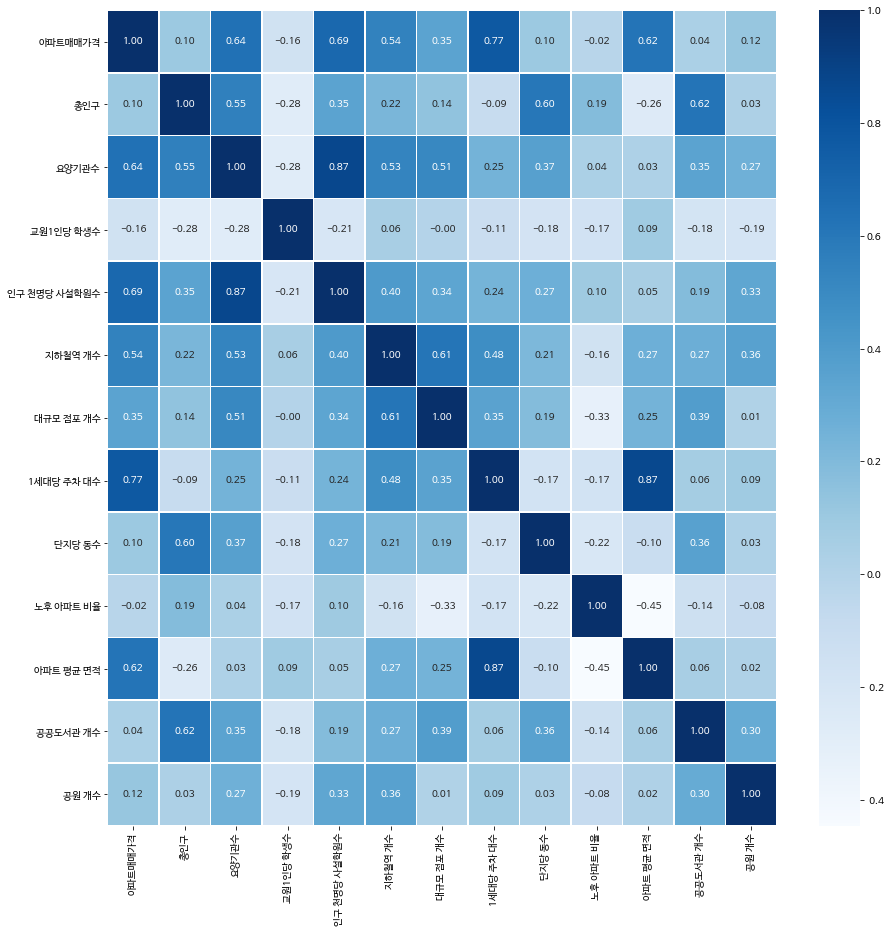

### 4) 아파트 매매 가격 -\> 지도 시각화<a href="#4)-아파트-매매-가격--%3E-지도-시각화" class="anchor-link">¶</a>

In \[30\]:

    # 행정구역 컬럼 생성

    df_map = df

    df["행정구역"] = df.index

In \[31\]:

    df

Out\[31\]:

|          | 아파트매매가격 | 총인구   | 요양기관수 | 교원1인당 학생수 | 인구 천명당 사설학원수 | 지하철역 개수 | 대규모 점포 개수 | 1세대당 주차 대수 | 단지당 동수 | 노후 아파트 비율 | 아파트 평균 면적 | 공공도서관 개수 | 공원 개수 | 행정구역 |
|----------|----------------|----------|------------|------------------|------------------------|---------------|------------------|-------------------|-------------|------------------|------------------|-----------------|-----------|----------|
| 행정구역 |                |          |            |                  |                        |               |                  |                   |             |                  |                  |                 |           |          |
| 강남구   | 1.800828e+09   | 550209.0 | 3088.0     | 13.30            | 4.2                    | 21.0          | 50.0             | 1.111869          | 8.228723    | 0.530646         | 137.660065       | 61.0            | 7.0       | 강남구   |
| 서초구   | 1.658633e+09   | 435107.0 | 1465.0     | 11.44            | 2.6                    | 12.0          | 29.0             | 1.175217          | 6.695652    | 0.436548         | 160.306013       | 77.0            | 6.0       | 서초구   |
| 용산구   | 1.522559e+09   | 245185.0 | 435.0      | 14.81            | 0.7                    | 10.0          | 23.0             | 1.365932          | 5.933333    | 0.528381         | 191.166808       | 40.0            | 2.0       | 용산구   |
| 송파구   | 1.201710e+09   | 682741.0 | 1527.0     | 13.16            | 1.6                    | 29.0          | 45.0             | 1.093984          | 10.620155   | 0.462204         | 142.237784       | 83.0            | 7.0       | 송파구   |
| 성동구   | 9.649932e+08   | 308979.0 | 593.0      | 16.51            | 1.0                    | 14.0          | 22.0             | 0.999528          | 6.839623    | 0.305944         | 137.403701       | 35.0            | 5.0       | 성동구   |
| 광진구   | 9.266670e+08   | 366972.0 | 723.0      | 19.95            | 1.2                    | 11.0          | 26.0             | 1.093651          | 4.317460    | 0.744020         | 144.006126       | 40.0            | 2.0       | 광진구   |
| 마포구   | 9.182095e+08   | 385925.0 | 929.0      | 18.75            | 1.8                    | 16.0          | 30.0             | 1.030708          | 6.824561    | 0.274308         | 137.672540       | 52.0            | 5.0       | 마포구   |
| 동작구   | 8.539662e+08   | 408912.0 | 762.0      | 20.01            | 1.2                    | 12.0          | 16.0             | 1.006190          | 6.476190    | 0.427503         | 139.303942       | 59.0            | 7.0       | 동작구   |
| 양천구   | 8.465589e+08   | 462285.0 | 816.0      | 13.71            | 2.3                    | 5.0           | 26.0             | 0.954957          | 8.526316    | 0.602368         | 127.059465       | 57.0            | 5.0       | 양천구   |
| 중구     | 7.978152e+08   | 136488.0 | 728.0      | 18.40            | 0.9                    | 23.0          | 59.0             | 1.093889          | 5.714286    | 0.254338         | 141.598651       | 48.0            | 5.0       | 중구     |
| 종로구   | 7.964525e+08   | 161869.0 | 668.0      | 17.68            | 1.7                    | 15.0          | 20.0             | 0.962400          | 5.130435    | 0.447266         | 144.732050       | 60.0            | 12.0      | 종로구   |
| 영등포구 | 7.669585e+08   | 400986.0 | 1001.0     | 11.90            | 1.2                    | 11.0          | 39.0             | 1.016395          | 5.013514    | 0.526738         | 136.449273       | 60.0            | 5.0       | 영등포구 |
| 강동구   | 7.377877e+08   | 440390.0 | 1023.0     | 12.79            | 1.5                    | 12.0          | 24.0             | 0.952718          | 8.188119    | 0.295964         | 134.739178       | 57.0            | 7.0       | 강동구   |
| 서대문구 | 6.804521e+08   | 323171.0 | 587.0      | 19.74            | 1.1                    | 5.0           | 12.0             | 0.916216          | 7.783784    | 0.412378         | 133.216625       | 38.0            | 4.0       | 서대문구 |
| 강서구   | 6.034907e+08   | 598273.0 | 1080.0     | 13.23            | 1.2                    | 10.0          | 27.0             | 0.979869          | 6.908497    | 0.649483         | 121.437469       | 78.0            | 9.0       | 강서구   |
| 성북구   | 5.854570e+08   | 454744.0 | 729.0      | 21.28            | 1.0                    | 9.0           | 42.0             | 0.922114          | 8.795082    | 0.259646         | 148.244037       | 75.0            | 3.0       | 성북구   |
| 동대문구 | 5.843585e+08   | 363023.0 | 832.0      | 22.69            | 1.1                    | 6.0           | 33.0             | 0.944839          | 6.565217    | 0.206288         | 145.880009       | 54.0            | 4.0       | 동대문구 |
| 관악구   | 5.356942e+08   | 517334.0 | 909.0      | 12.04            | 0.9                    | 4.0           | 23.0             | 0.860312          | 7.225806    | 0.346542         | 122.117424       | 61.0            | 2.0       | 관악구   |
| 은평구   | 5.234770e+08   | 484546.0 | 874.0      | 13.19            | 1.1                    | 13.0          | 29.0             | 1.113796          | 7.440367    | 0.177428         | 155.601943       | 83.0            | 7.0       | 은평구   |
| 구로구   | 5.103450e+08   | 439371.0 | 741.0      | 15.86            | 1.0                    | 7.0           | 38.0             | 0.948651          | 6.424000    | 0.482262         | 128.079439       | 98.0            | 4.0       | 구로구   |
| 강북구   | 4.680509e+08   | 317695.0 | 628.0      | 13.10            | 0.7                    | 3.0           | 22.0             | 0.813590          | 8.589744    | 0.419746         | 126.471749       | 54.0            | 4.0       | 강북구   |
| 중랑구   | 4.448039e+08   | 402024.0 | 689.0      | 14.97            | 0.7                    | 8.0           | 14.0             | 0.957273          | 5.685393    | 0.618051         | 122.593285       | 54.0            | 6.0       | 중랑구   |
| 노원구   | 4.439864e+08   | 537303.0 | 952.0      | 18.01            | 1.4                    | 13.0          | 19.0             | 0.756863          | 7.339901    | 0.832261         | 95.235442        | 57.0            | 2.0       | 노원구   |
| 금천구   | 4.333635e+08   | 251820.0 | 475.0      | 11.53            | 1.0                    | 1.0           | 23.0             | 0.914615          | 6.025641    | 0.461405         | 122.509416       | 29.0            | 4.0       | 금천구   |
| 도봉구   | 4.061438e+08   | 335631.0 | 485.0      | 14.45            | 1.0                    | 3.0           | 15.0             | 0.853939          | 6.448980    | 0.789729         | 111.216666       | 42.0            | 6.0       | 도봉구   |

In \[32\]:

    # 서울시 행정구역 json 불러오기
    state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

In \[33\]:

    # 시각화 함수

    def draw_data(x, color):
      m.choropleth(
          geo_data=state_geo,
          name=x,
          data=df,
          columns=["행정구역", x],
          key_on='feature.properties.name',
          fill_color=color,
          fill_opacity = 0.9,
          line_opacity = 0.6,
          color = 'gray',
          legend = True,
          legend_name = x
      )

    def scatter_draw(x):
      plt.scatter(df["아파트매매가격"], df[x], color = 'black')
      plt.xlabel("아파트매매가격")
      plt.ylabel(x)

In \[34\]:

    # 아파트 매매 가격 -> 지도 시각화

    m = folium.Map(location=[37.562225, 126.978555], width = "100%", height = "100%", tiles="Mapbox Control Room", zoom_start=11)
    draw_data("아파트매매가격", "Blues")

    for i in range(25):
      folium.Marker(location=[df_geo.loc[i][1], df_geo.loc[i][2]], 
                  icon=folium.DivIcon(
                      icon_size=(100, 20),
                      html= '<div style="font-size: 12pt; font-weight: bold; font-family: 바탕체; color: black; text-align: center;">%s</div>' % df_geo.loc[i][0])
                ).add_to(m)

    m

Out\[34\]:

<span style="color:#565656">Make this Notebook Trusted to load map: File
-\> Trust Notebook</span>

### 5) 그래프<a href="#5)-그래프" class="anchor-link">¶</a>

#### 아파트 매매 가격<a href="#아파트-매매-가격" class="anchor-link">¶</a>

In \[35\]:

    df_order = df.sort_values(by = "아파트매매가격", ascending = False)
    df_order["아파트매매가격"].sort_values().plot(kind = "barh" , figsize = (10,8) , color = "orange")

    plt.xlabel('아파트 매매 가격')
    plt.ylabel('행정구역')
    plt.ticklabel_format(axis = "x", style='plain') # 지수 표현을 숫자 표현으로 변경
    plt.grid(color = 'white',axis = 'x')

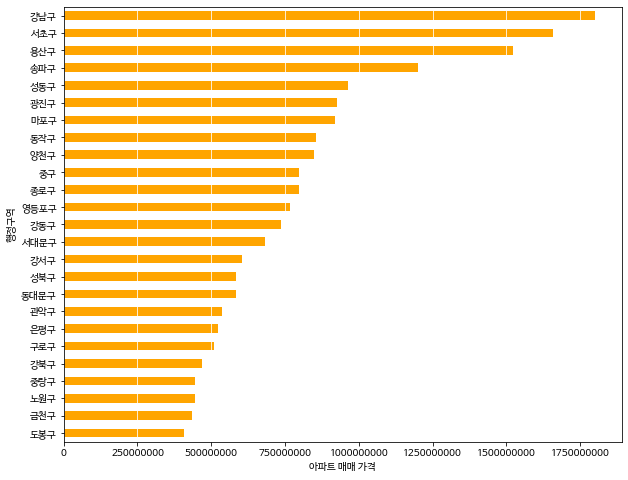

In \[36\]:

    ax = sns.distplot(df["아파트매매가격"]/1e8, bins = 15, color = "orange")

    ax.set_xlabel("아파트매매가격(억)")
    ax.set_ylabel("Density")

Out\[36\]:

    Text(0, 0.5, 'Density')

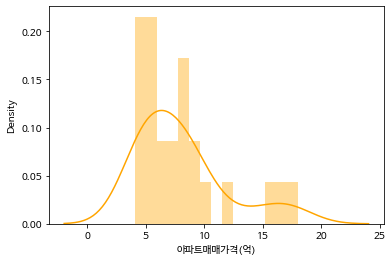

In \[37\]:

    from google.colab import files
    uploaded = files.upload()
    from IPython.display import Image
    Image('생활권.png')

Upload widget is only available when the cell has been executed in the
current browser session. Please rerun this cell to enable.

    Saving 생활권.png to 생활권 (1).png

Out\[37\]:

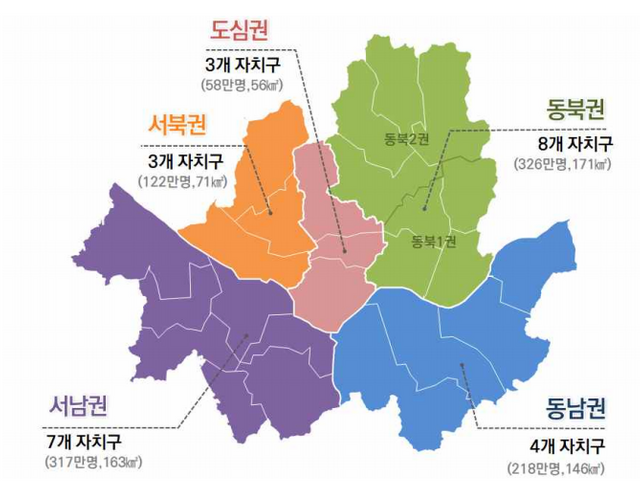

In \[38\]:

    df["생활권"] = 0
    for i in ["용산구","중구","종로구"]:
        df["생활권"][i] ='도심'

    for i in ["은평구","서대문구","마포구"]:
        df["생활권"][i] ='동북'

    for i in ["성동구","동대문구","성북구","강북구","도봉구","노원구","중랑구","광진구"]:
        df["생활권"][i] ='서북'

    for i in ["강서구","양천구","구로구","영등포구","동작구","금천구","관악구"]:
        df["생활권"][i] ='서남'

    for i in ["서초구","강남구","송파구","강동구"]:
        df["생활권"][i] = '동남'

In \[39\]:

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    box = ax.boxplot([df[df["생활권"] == "도심"]["아파트매매가격"], df[df["생활권"] == "동북"]["아파트매매가격"], df[df["생활권"] == "서북"]["아파트매매가격"], df[df["생활권"] == "서남"]["아파트매매가격"],
                      df[df["생활권"] == "동남"]["아파트매매가격"]], labels = ["도심", "동북", "서북", "서남", "동남"])
    ax.set_title("서울 생활권에 따른 아파트 매매가 분류")
    ax.set_ylabel("아파트매매가")

Out\[39\]:

    Text(0, 0.5, '아파트매매가')

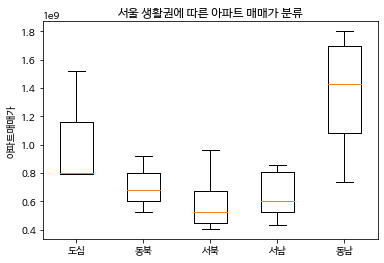

In \[40\]:

    df.drop(["행정구역", "생활권"], axis = 1, inplace = True)

In \[41\]:

    # 각 변수를 표준화

    import sklearn
    from sklearn.preprocessing import *

    ss_data=StandardScaler().fit_transform(df)
    # print(ss_data)

    # 표준화된 변수를 다시 dataframe으로

    df1 = pd.DataFrame(ss_data)

    # df1의 index 재설정

    df1["행정구역"] = df.index
    df1.set_index("행정구역", inplace = True)

    # df1의 컬럼명 재설정
    df1.columns = index_list

In \[42\]:

    # "아파트매매가격", "아파트 평균 면적", "1세대당 주차 대수"만 따로 plot으로 비교

    plt.figure(figsize = (20,20))
    df1[["아파트매매가격", "아파트 평균 면적", "1세대당 주차 대수"]].plot()
    plt.xticks(np.arange(0, 25, 1), labels = list(df.index), rotation=55)

Out\[42\]:

    ([<matplotlib.axis.XTick at 0x7fd6d96d3b90>,
      <matplotlib.axis.XTick at 0x7fd6d984c950>,
      <matplotlib.axis.XTick at 0x7fd6d968e650>,
      <matplotlib.axis.XTick at 0x7fd6d96a2350>,
      <matplotlib.axis.XTick at 0x7fd6d96a28d0>,
      <matplotlib.axis.XTick at 0x7fd6d96a2e10>,
      <matplotlib.axis.XTick at 0x7fd6d96a93d0>,
      <matplotlib.axis.XTick at 0x7fd6d96a2390>,
      <matplotlib.axis.XTick at 0x7fd6d96988d0>,
      <matplotlib.axis.XTick at 0x7fd6d96a9310>,
      <matplotlib.axis.XTick at 0x7fd6d96a9190>,
      <matplotlib.axis.XTick at 0x7fd6d96b1550>,
      <matplotlib.axis.XTick at 0x7fd6d96b1a90>,
      <matplotlib.axis.XTick at 0x7fd6d96b1b90>,
      <matplotlib.axis.XTick at 0x7fd6d96b8550>,
      <matplotlib.axis.XTick at 0x7fd6d96b8a90>,
      <matplotlib.axis.XTick at 0x7fd6d96b8b90>,
      <matplotlib.axis.XTick at 0x7fd6d96b8810>,
      <matplotlib.axis.XTick at 0x7fd6d96b1250>,
      <matplotlib.axis.XTick at 0x7fd6d96a9110>,
      <matplotlib.axis.XTick at 0x7fd6d96c0410>,
      <matplotlib.axis.XTick at 0x7fd6d96c08d0>,
      <matplotlib.axis.XTick at 0x7fd6d96c0e10>,
      <matplotlib.axis.XTick at 0x7fd6d964a390>,
      <matplotlib.axis.XTick at 0x7fd6d964a8d0>],
     [Text(0, 0, '강남구'),
      Text(0, 0, '서초구'),
      Text(0, 0, '용산구'),
      Text(0, 0, '송파구'),
      Text(0, 0, '성동구'),
      Text(0, 0, '광진구'),
      Text(0, 0, '마포구'),
      Text(0, 0, '동작구'),
      Text(0, 0, '양천구'),
      Text(0, 0, '중구'),
      Text(0, 0, '종로구'),
      Text(0, 0, '영등포구'),
      Text(0, 0, '강동구'),
      Text(0, 0, '서대문구'),
      Text(0, 0, '강서구'),
      Text(0, 0, '성북구'),
      Text(0, 0, '동대문구'),
      Text(0, 0, '관악구'),
      Text(0, 0, '은평구'),
      Text(0, 0, '구로구'),
      Text(0, 0, '강북구'),
      Text(0, 0, '중랑구'),
      Text(0, 0, '노원구'),
      Text(0, 0, '금천구'),
      Text(0, 0, '도봉구')])

    <Figure size 1440x1440 with 0 Axes>

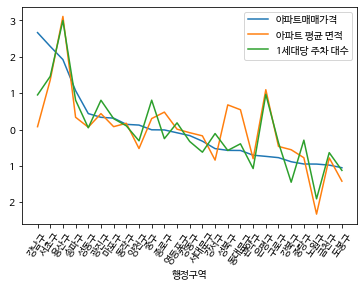

In \[43\]:

    df.sort_values(by = "아파트매매가격", ascending = False, inplace = True)

In \[44\]:

    ## 상관관계를 통하여 확인함...

    plt.figure(figsize = (10,10))
    plt.scatter(df["아파트 평균 면적"] , df["1세대당 주차 대수"], s = 1e2 , c= df["아파트매매가격"], cmap = 'hot')

    plt.xlabel("아파트 평균 면적")
    plt.ylabel("1세대당 주차 대수")
    plt.grid()
    plt.colorbar().ax.set_ylabel('아파트매매가격')

    for n in range(5):
        plt.text(df["아파트 평균 면적"][n] , df["1세대당 주차 대수"][n] , df.index[n], fontsize = 10)

    for n in range(5):
        plt.text(df["아파트 평균 면적"][-n-1] , df["1세대당 주차 대수"][-n-1] , df.index[-n-1], fontsize = 10)

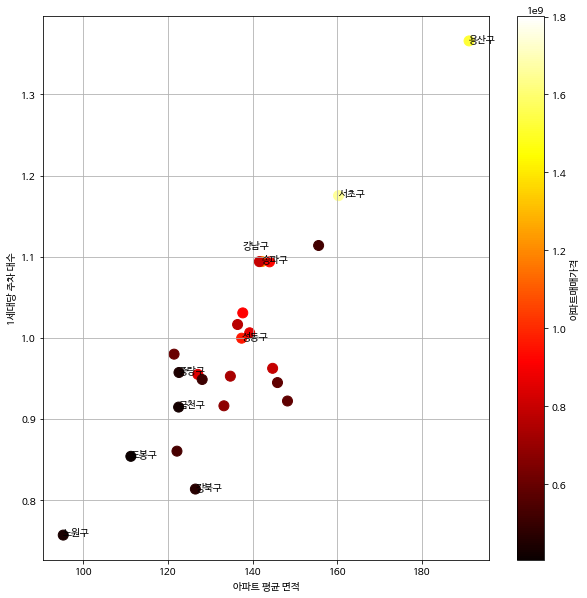

In \[45\]:

    plt.figure(figsize = (20,20))
    df1[["아파트매매가격", "인구 천명당 사설학원수", "요양기관수"]].plot()
    plt.xticks(np.arange(0, 25, 1), labels = list(df.index), rotation=55)

    # 학군과 사설학원수의 상관성
    # http://blog.naver.com/PostView.nhn?blogId=crystal0121&logNo=222061355845&parentCategoryNo=78&categoryNo=&viewDate=&isShowPopularPosts=true&from=search

Out\[45\]:

    ([<matplotlib.axis.XTick at 0x7fd6d96796d0>,
      <matplotlib.axis.XTick at 0x7fd6d954e390>,
      <matplotlib.axis.XTick at 0x7fd6d9508510>,
      <matplotlib.axis.XTick at 0x7fd6d9519490>,
      <matplotlib.axis.XTick at 0x7fd6d9519790>,
      <matplotlib.axis.XTick at 0x7fd6d9519cd0>,
      <matplotlib.axis.XTick at 0x7fd6d9519810>,
      <matplotlib.axis.XTick at 0x7fd6d9510690>,
      <matplotlib.axis.XTick at 0x7fd6d964a490>,
      <matplotlib.axis.XTick at 0x7fd6d951f8d0>,
      <matplotlib.axis.XTick at 0x7fd6d951fc90>,
      <matplotlib.axis.XTick at 0x7fd6d95284d0>,
      <matplotlib.axis.XTick at 0x7fd6d9528a10>,
      <matplotlib.axis.XTick at 0x7fd6d9528850>,
      <matplotlib.axis.XTick at 0x7fd6d952e4d0>,
      <matplotlib.axis.XTick at 0x7fd6d952ea10>,
      <matplotlib.axis.XTick at 0x7fd6d952e850>,
      <matplotlib.axis.XTick at 0x7fd6d9528cd0>,
      <matplotlib.axis.XTick at 0x7fd6d951f9d0>,
      <matplotlib.axis.XTick at 0x7fd6d95100d0>,
      <matplotlib.axis.XTick at 0x7fd6d9535410>,
      <matplotlib.axis.XTick at 0x7fd6d9535950>,
      <matplotlib.axis.XTick at 0x7fd6d9535e90>,
      <matplotlib.axis.XTick at 0x7fd6d9540410>,
      <matplotlib.axis.XTick at 0x7fd6d9540950>],
     [Text(0, 0, '강남구'),
      Text(0, 0, '서초구'),
      Text(0, 0, '용산구'),
      Text(0, 0, '송파구'),
      Text(0, 0, '성동구'),
      Text(0, 0, '광진구'),
      Text(0, 0, '마포구'),
      Text(0, 0, '동작구'),
      Text(0, 0, '양천구'),
      Text(0, 0, '중구'),
      Text(0, 0, '종로구'),
      Text(0, 0, '영등포구'),
      Text(0, 0, '강동구'),
      Text(0, 0, '서대문구'),
      Text(0, 0, '강서구'),
      Text(0, 0, '성북구'),
      Text(0, 0, '동대문구'),
      Text(0, 0, '관악구'),
      Text(0, 0, '은평구'),
      Text(0, 0, '구로구'),
      Text(0, 0, '강북구'),
      Text(0, 0, '중랑구'),
      Text(0, 0, '노원구'),
      Text(0, 0, '금천구'),
      Text(0, 0, '도봉구')])

    <Figure size 1440x1440 with 0 Axes>

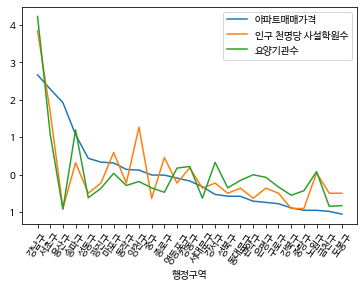

# 끝<a href="#끝" class="anchor-link">¶</a>